# Advanced Extra Exercise Project - PyTorch for non linear Regression

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## True model and training data



> ground-truth model



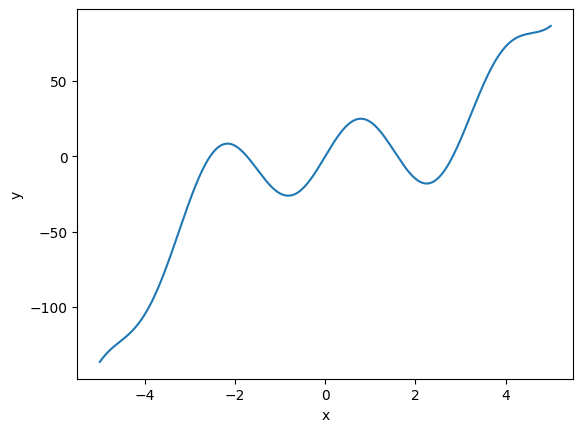

In [ ]:
def goalFun(x):
    return(x**3 - x**2 + 25 * np.sin(2*x))

# create linear sequence (x) and apply goalFun (y)
x = np.linspace(start = -5, stop =5, num = 1000)
y = goalFun(x)

# plot the function
d = pd.DataFrame({'x' : x, 'y' : y})
sns.lineplot(data = d, x = 'x', y = 'y')
plt.show()



> generate training data (with noise)



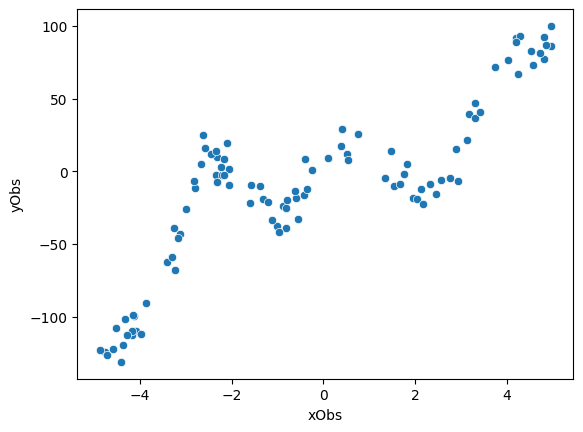

In [ ]:
nObs = 100 # number of observations

# get noise around y observations
yNormal = torch.distributions.Normal(loc=0.0, scale=10)
yNoise  = yNormal.sample([nObs])

# get observations
xObs = 10*torch.rand([nObs])-5    # uniform from [-5,5]
yObs = xObs**3 - xObs**2 + 25 * torch.sin(2*xObs) + yNoise

# plot the data
d = pd.DataFrame({'xObs' : xObs, 'yObs' : yObs})
sns.scatterplot(data = d, x = 'xObs', y = 'yObs')
plt.show()

## Defining the MLP using PyTorch’s built-in modules



> network dimension parameters



In [ ]:
nInput  = 1
nHidden = 10
nOutput = 1


###More explicit definition NN module
> set up multi-layer perceptron w/ PyTorch (explicit version)



In [ ]:
class MLPexplicit(nn.Module):
    '''
    Multi-layer perceptron for non-linear regression.
    '''
    def __init__(self, nInput, nHidden, nOutput):
        super(MLPexplicit, self).__init__()
        self.nInput  = nInput
        self.nHidden = nHidden
        self.nOutput = nOutput
        self.linear1 = nn.Linear(self.nInput, self.nHidden)
        self.linear2 = nn.Linear(self.nHidden, self.nHidden)
        self.linear3 = nn.Linear(self.nHidden, self.nHidden)
        self.linear4 = nn.Linear(self.nHidden, self.nOutput)
        self.ReLU    = nn.ReLU()

    def forward(self, x):
        h1 = self.ReLU(self.linear1(x))
        h2 = self.ReLU(self.linear2(h1))
        h3 = self.ReLU(self.linear3(h2))
        output = self.linear4(h3)
        return(output)

mlpExplicit = MLPexplicit(nInput, nHidden, nOutput)

In [ ]:
for p in mlpExplicit.parameters():
    print(p.detach().numpy().round(4))

[[ 0.742 ]
 [ 0.525 ]
 [ 0.7152]
 [-0.0302]
 [ 0.4845]
 [ 0.1057]
 [ 0.4098]
 [-0.1746]
 [-0.0671]
 [ 0.9484]]
[-0.609   0.8661  0.3466  0.1963 -0.0942  0.7391  0.5828  0.5259  0.4029
 -0.5536]
[[ 0.2213 -0.1499 -0.1237 -0.1023 -0.1048  0.118  -0.099  -0.0339 -0.0089
   0.2873]
 [ 0.1353  0.035   0.0415  0.1066 -0.0428  0.1456 -0.1749 -0.0643 -0.0227
  -0.233 ]
 [-0.0949 -0.1872  0.1941 -0.1262 -0.1294 -0.2929 -0.0292 -0.1264 -0.1247
   0.3157]
 [ 0.3002  0.1287 -0.255  -0.0156 -0.114   0.0725 -0.2404  0.0849 -0.1652
  -0.0197]
 [-0.0618  0.0583 -0.2085 -0.0299 -0.0679 -0.2307  0.312  -0.2932 -0.2311
  -0.1685]
 [ 0.0062  0.2583 -0.2001 -0.0811 -0.2776  0.1321 -0.2487 -0.299   0.1445
   0.2117]
 [ 0.1269  0.1538  0.2806  0.1959 -0.2904 -0.1655 -0.3012  0.053   0.1421
  -0.1997]
 [-0.0682 -0.2397  0.0701 -0.2512  0.2597  0.2035  0.2573  0.0916 -0.1398
  -0.0622]
 [-0.0356 -0.1594 -0.2207 -0.0889 -0.3116  0.1994  0.0369 -0.0916  0.2675
  -0.1442]
 [-0.2727 -0.2155 -0.1483 -0.2964 -0.1828


### More concise definition of NN module
> set up multi-layer perceptron w/ PyTorch (condensed version)



In [ ]:
class MLPcondensed(nn.Module):
    '''
    Multi-layer perceptron for non-linear regression.
    '''
    def __init__(self, nInput, nHidden, nOutput):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(nInput, nHidden),
            nn.ReLU(),
            nn.Linear(nHidden, nHidden),
            nn.ReLU(),
            nn.Linear(nHidden, nHidden),
            nn.ReLU(),
            nn.Linear(nHidden, nOutput)
        )

    def forward(self, x):
        return(self.layers(x))

mlpCondensed = MLPcondensed(nInput, nHidden, nOutput)

In [ ]:
model = mlpCondensed

## Preparing the training data


In [ ]:
class nonLinearRegressionData(Dataset):
    '''
    Custom 'Dataset' object for our regression data.
    Must implement these functions: __init__, __len__, and __getitem__.
    '''

    def __init__(self, xObs, yObs):
        self.xObs = torch.reshape(xObs, (len(xObs), 1))
        self.yObs = torch.reshape(yObs, (len(yObs), 1))

    def __len__(self):
        return(len(self.xObs))

    def __getitem__(self, idx):
        return(xObs[idx], yObs[idx])

# instantiate Dataset object for current training data
d = nonLinearRegressionData(xObs, yObs)

# instantiate DataLoader
#    we use the 4 batches of 25 observations each (full data  has 100 observations)
#    we also shuffle the data
train_dataloader = DataLoader(d, batch_size=25 , shuffle=True)


In [ ]:
for i, data in enumerate(train_dataloader, 0):
    input, target = data
    print("In: ", input)
    print("Out:", target,"\n")

In:  tensor([ 1.5391,  1.9504,  2.3183, -2.3211, -0.8846, -3.1304,  0.7529, -0.4002,
        -4.8720,  0.1002, -4.0829, -2.8026,  2.1797,  4.5733,  2.7617,  3.7495,
        -1.0128,  4.2841, -4.7660,  4.7142,  0.5112, -1.5749, -2.6695, -4.3686,
        -3.2892])
Out: tensor([ -10.3005,  -18.2218,   -8.8620,    9.6036,  -23.9666,  -43.2801,
          25.6433,    8.5227, -122.9687,    9.1149, -109.8119,  -11.2989,
         -22.2962,   73.3035,   -4.6463,   71.5340,  -37.2898,   93.0966,
        -124.5166,   81.3570,   12.1855,   -9.6981,    4.8834, -119.2249,
         -58.9720]) 

In:  tensor([ 0.5447, -2.3122, -0.2467, -0.3525, -0.5472,  4.2020, -1.3899, -0.9639,
         2.8882,  1.8284, -4.3188, -3.2590, -4.1387, -4.1298,  4.9589, -1.2048,
         4.5197, -2.0891,  3.3049, -2.9843, -2.3447,  4.9562,  1.7501,  3.4066,
        -4.2698])
Out: tensor([   7.7090,   -7.3417,    0.8300,  -12.3984,  -33.0865,   88.6992,
          -9.7796,  -41.5637,   15.2538,    4.8476, -101.3394,  -38.9102

## Training the model

In [ ]:
# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
nTrainSteps = 50000

# Run the training loop
for epoch in range(0, nTrainSteps):

  # Set current loss value
  current_loss = 0.0

  # Iterate over the DataLoader for training data
  for i, data in enumerate(train_dataloader, 0):
    # Get inputs
    inputs, targets = data
    # Zero the gradients
    optimizer.zero_grad()
    # Perform forward pass (make sure to supply the input in the right way)
    outputs = model(torch.reshape(inputs, (len(inputs), 1))).squeeze()
    # Compute loss
    loss = loss_function(outputs, targets)
    # Perform backward pass
    loss.backward()
    # Perform optimization
    optimizer.step()
    # Print statistics
    current_loss += loss.item()

  if (epoch + 1) % 2500 == 0:
      print('Loss after epoch %5d: %.3f' %
            (epoch + 1, current_loss))
      current_loss = 0.0

# Process is complete.
print('Training process has finished.')

Loss after epoch  2500: 3909.415
Loss after epoch  5000: 2567.349
Loss after epoch  7500: 960.716
Loss after epoch 10000: 705.482
Loss after epoch 12500: 450.870
Loss after epoch 15000: 398.424
Loss after epoch 17500: 383.637
Loss after epoch 20000: 374.694
Loss after epoch 22500: 368.055
Loss after epoch 25000: 361.885
Loss after epoch 27500: 355.957
Loss after epoch 30000: 350.270
Loss after epoch 32500: 343.364
Loss after epoch 35000: 336.796
Loss after epoch 37500: 329.281
Loss after epoch 40000: 321.988
Loss after epoch 42500: 315.127
Loss after epoch 45000: 309.039
Loss after epoch 47500: 293.494
Loss after epoch 50000: 288.985
Training process has finished.


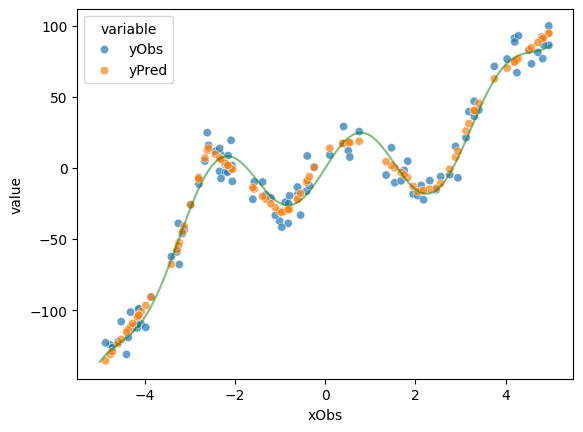

In [ ]:
yPred = np.array([model.forward(torch.tensor([o])).detach().numpy() for o in xObs]).flatten()

# plot the data
d = pd.DataFrame({'xObs' : xObs.detach().numpy(),
                  'yObs' : yObs.detach().numpy(),
                  'yPred': yPred})
dWide = pd.melt(d, id_vars = 'xObs', value_vars= ['yObs', 'yPred'])
sns.scatterplot(data = dWide, x = 'xObs', y = 'value', hue = 'variable', alpha = 0.7)
x = np.linspace(start = -5, stop =5, num = 1000)
y = goalFun(x)
plt.plot(x,y, color='g', alpha = 0.5)
plt.show()